# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import sys
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from sqlalchemy import create_engine

# For machine learning
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

import warnings

warnings.simplefilter('ignore')

# For nlp
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline, FeatureUnion
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import pickle


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [16]:
# load data from database
engine = create_engine('sqlite:///disaster.db')
df = pd.read_sql_table(table_name='disaster_response_table', con=engine)
X = df['message']
Y = df.iloc[:,4:]

In [17]:
Y.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
Y.related.value_counts()

1    19906
0     6122
Name: related, dtype: int64

In [5]:
from nltk.corpus import stopwords

### 2. Write a tokenization function to process your text data

In [6]:
url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

def tokenize(text):
    # Detect URLs
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, 'urlplaceholder')
    
    # Normalize and tokenize and remove punctuation
    tokens = nltk.word_tokenize(re.sub(r"[^a-zA-Z0-9]", " ", text.lower()))
    
    # Remove stopwords
    tokens = [t for t in tokens if t not in stopwords.words('english')]

    # Lemmatize
    lemmatizer=WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    
    return tokens

In [7]:
text='Weather update - a cold front from Cuba that???'

In [8]:
tokenize(text)

['weather', 'update', 'cold', 'front', 'cuba']

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [9]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer = tokenize))
    , ('tfidf', TfidfTransformer())
    , ('clf', MultiOutputClassifier(RandomForestClassifier()))])

pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'vect', 'tfidf', 'clf', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'clf__estimator__bootstrap', 'clf__estimator__class_weight', 'clf__estimator__criterion', 'clf__estimator__max_depth', 'clf__estimator__max_features', 'clf__estimator__max_leaf_nodes', 'clf__estimator__min_impurity_decrease', 'clf__estimator__min_impurity_split', 'clf__estimator__min_samples_leaf', 'clf__estimator__min_samples_split', 'clf__estimator__min_weight_fraction_leaf', 'clf__estimator__n_estimators', 'clf__estimator__n_jobs', 'clf__estimator__oob_score', 'clf__estimator__random_state', 'clf__estimator__verbose', 'clf__estimator__

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,random_state = 42)

In [60]:
%%time
pipeline.fit(X_train, Y_train)

CPU times: user 2min 25s, sys: 6.5 s, total: 2min 31s
Wall time: 2min 32s


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...oob_score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=1))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [79]:
Y_pred = pipeline.predict(X_test)
    
# Calculate the accuracy for each of them.
for i in range(len(Y.columns)):
    print('Category: {} '.format(Y.columns[i]))
    print(classification_report(Y_test.iloc[:, i].values, Y_pred[:, i]))
    print('Accuracy {}\n\n'.format(accuracy_score(Y_test.iloc[:, i].values, Y_pred[:, i])))
    print('F1 {}\n\n'.format(f1_score(Y_test.iloc[:, i].values, Y_pred[:, i],average='weighted')))

Category: related 
             precision    recall  f1-score   support

          0       0.66      0.44      0.53      1569
          1       0.84      0.93      0.88      4938

avg / total       0.80      0.81      0.80      6507

Accuracy 0.8103580759182419


F1 0.7966128896518204


Category: request 
             precision    recall  f1-score   support

          0       0.90      0.98      0.93      5403
          1       0.79      0.45      0.57      1104

avg / total       0.88      0.89      0.87      6507

Accuracy 0.8856615952051636


F1 0.8722874483985462


Category: offer 
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6481
          1       0.00      0.00      0.00        26

avg / total       0.99      1.00      0.99      6507

Accuracy 0.9960043030582449


F1 0.9940104539760527


Category: aid_related 
             precision    recall  f1-score   support

          0       0.75      0.86      0.80      3793
        

In [80]:
print(classification_report(Y_test.iloc[:, 1:].values, np.array([x[1:] for x in Y_pred]), target_names = Y.columns))

                        precision    recall  f1-score   support

               related       0.79      0.45      0.57      1104
               request       0.00      0.00      0.00        26
                 offer       0.75      0.61      0.67      2714
           aid_related       0.63      0.08      0.14       542
          medical_help       0.70      0.11      0.19       347
      medical_products       0.53      0.05      0.09       192
     search_and_rescue       0.33      0.01      0.01       133
              security       0.61      0.09      0.16       225
              military       0.84      0.21      0.33       430
                 water       0.82      0.47      0.59       731
                  food       0.78      0.27      0.40       598
               shelter       0.62      0.08      0.14       101
              clothing       0.89      0.05      0.09       168
                 money       0.33      0.01      0.03        68
        missing_people       0.65      

In [81]:
# Hmmmm F-1 score is low, Lets see the distribution of class
Y.sum()/len(Y)

related                   0.764792
request                   0.171892
offer                     0.004534
aid_related               0.417243
medical_help              0.080068
medical_products          0.050446
search_and_rescue         0.027816
security                  0.018096
military                  0.033041
water                     0.064239
food                      0.112302
shelter                   0.088904
clothing                  0.015560
money                     0.023206
missing_people            0.011449
refugees                  0.033618
death                     0.045874
other_aid                 0.132396
infrastructure_related    0.065506
transport                 0.046143
buildings                 0.051214
electricity               0.020440
tools                     0.006109
hospitals                 0.010873
shops                     0.004610
aid_centers               0.011872
other_infrastructure      0.044222
weather_related           0.280352
floods              

Text(0.5,0,'Number of messages')

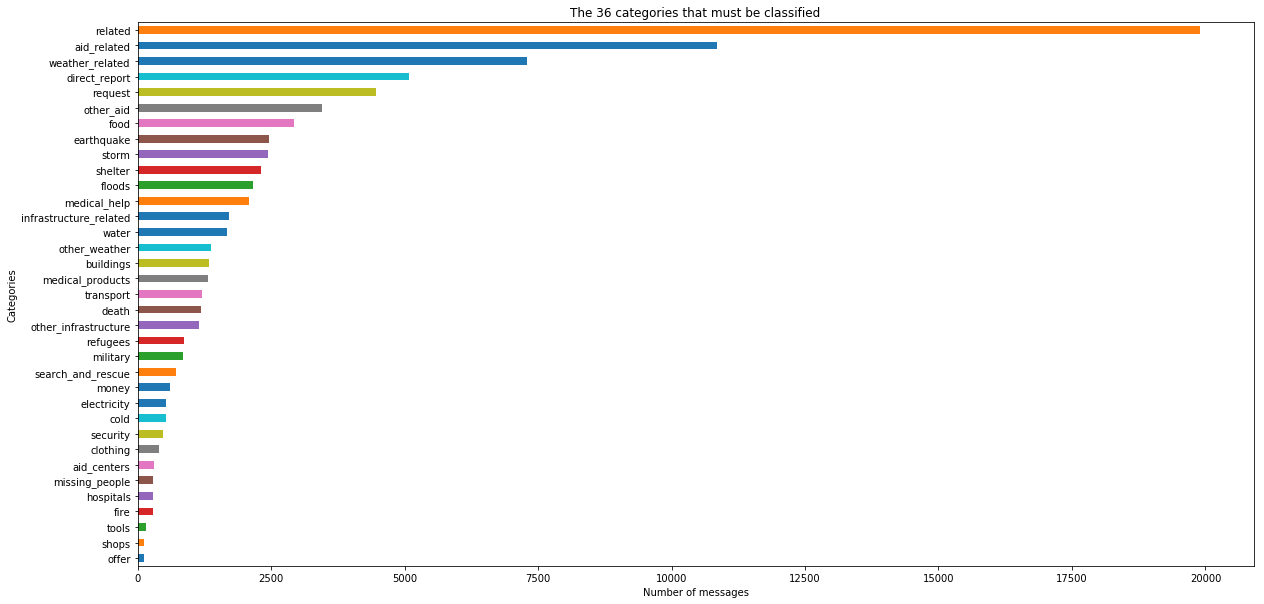

In [82]:
cats=df.columns[4:]
plt.figure(figsize=(20,10))
df[cats].sum().sort_values().plot.barh()
plt.title('The 36 categories that must be classified')
plt.ylabel('Categories')
plt.xlabel('Number of messages')

### 6. Improve your model
Use grid search to find better parameters. 

In [11]:
%%time
#grid search

parameters = {'vect__min_df': [1, 5],
              'tfidf__use_idf':[True, False],
              'clf__estimator__n_estimators':[10, 25], 
              'clf__estimator__min_samples_split':[2, 5, 10]}

pipeline_cv = GridSearchCV(estimator=pipeline, param_grid=parameters, verbose=3)

CPU times: user 169 µs, sys: 21 µs, total: 190 µs
Wall time: 204 µs


### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [12]:
%%time
pipeline_cv.fit(X_train, Y_train)
print('Best Parameters:', pipeline_cv.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=1 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=1, score=0.24081758106654372, total= 2.1min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.1min remaining:    0.0s


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=1, score=0.22790840633164286, total= 2.1min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.2min remaining:    0.0s


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=1, score=0.24481327800829875, total= 2.1min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=5 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=5, score=0.2417396649761795, total= 1.9min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=5 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=5, score=0.23297986783463961, total= 1.9min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=5 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=5, score=0.2564930075303519, total= 1.9min
[CV] clf__estimator__min_samples_split=2, clf__est

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 236.4min finished


Best Parameters: {'clf__estimator__min_samples_split': 10, 'clf__estimator__n_estimators': 25, 'tfidf__use_idf': False, 'vect__min_df': 5}
CPU times: user 3h 44min 56s, sys: 13min 7s, total: 3h 58min 4s
Wall time: 3h 59min 20s


In [13]:
pickle.dump(pipeline_cv, open('disaster_model.sav', 'wb'))

In [16]:
loaded_model = pickle.load(open('disaster_model.sav', 'rb'))

In [17]:

Y_pred = loaded_model.predict(X_test)
    
print(classification_report(Y_test.iloc[:, 1:].values, np.array([x[1:] for x in Y_pred]), target_names = Y.columns))

                        precision    recall  f1-score   support

               related       0.78      0.50      0.61      1104
               request       0.00      0.00      0.00        26
                 offer       0.74      0.71      0.73      2714
           aid_related       0.62      0.10      0.18       542
          medical_help       0.70      0.15      0.25       347
      medical_products       0.59      0.09      0.15       192
     search_and_rescue       0.50      0.01      0.01       133
              security       0.75      0.17      0.28       225
              military       0.89      0.43      0.58       430
                 water       0.80      0.70      0.75       731
                  food       0.81      0.48      0.60       598
               shelter       0.76      0.13      0.22       101
              clothing       0.78      0.08      0.15       168
                 money       0.50      0.01      0.03        68
        missing_people       0.54      

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [83]:
from sklearn.base import BaseEstimator, TransformerMixin
class StartingVerbExtractor(BaseEstimator, TransformerMixin):

    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            first_word, first_tag = pos_tags[0]
            if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                return True
        return False

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)

In [92]:
new_pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(
        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced'))
    ))
])


In [14]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [93]:
new_pipeline.fit(X_train, Y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...er='best'),
          learning_rate=1.0, n_estimators=50, random_state=None),
           n_jobs=1))])

In [94]:
Y_pred = new_pipeline.predict(X_test)
    
# Calculate the accuracy for each of them.
for i in range(len(Y.columns)):
    print('Category: {} '.format(Y.columns[i]))
    print(classification_report(Y_test.iloc[:, i].values, Y_pred[:, i]))
    print('Accuracy {}\n\n'.format(accuracy_score(Y_test.iloc[:, i].values, Y_pred[:, i])))
    print('F1 {}\n\n'.format(f1_score(Y_test.iloc[:, i].values, Y_pred[:, i],average='weighted')))

Category: related 
             precision    recall  f1-score   support

          0       0.47      0.77      0.58      1569
          1       0.91      0.72      0.80      4938

avg / total       0.80      0.73      0.75      6507

Accuracy 0.7327493468572307


F1 0.750071088505151


Category: request 
             precision    recall  f1-score   support

          0       0.94      0.85      0.90      5403
          1       0.51      0.75      0.61      1104

avg / total       0.87      0.84      0.85      6507

Accuracy 0.8366374673428615


F1 0.848093765370342


Category: offer 
             precision    recall  f1-score   support

          0       1.00      0.93      0.96      6481
          1       0.01      0.27      0.03        26

avg / total       0.99      0.93      0.96      6507

Accuracy 0.9253112033195021


F1 0.9574348583528356


Category: aid_related 
             precision    recall  f1-score   support

          0       0.77      0.82      0.79      3793
          

In [95]:
print(classification_report(Y_test.iloc[:, 1:].values, np.array([x[1:] for x in Y_pred]), target_names = Y.columns))

                        precision    recall  f1-score   support

               related       0.51      0.75      0.61      1104
               request       0.01      0.27      0.03        26
                 offer       0.72      0.66      0.69      2714
           aid_related       0.35      0.66      0.46       542
          medical_help       0.25      0.68      0.36       347
      medical_products       0.11      0.53      0.18       192
     search_and_rescue       0.05      0.49      0.09       133
              security       0.30      0.74      0.42       225
              military       0.49      0.88      0.63       430
                 water       0.67      0.86      0.75       731
                  food       0.50      0.79      0.61       598
               shelter       0.18      0.66      0.29       101
              clothing       0.22      0.78      0.35       168
                 money       0.04      0.51      0.08        68
        missing_people       0.16      

In [10]:
#https://medium.com/swlh/the-hyperparameter-cheat-sheet-770f1fed32ff
pipeline_ada = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(
        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced'))
    ))
])

parameters_ada = {
    'clf__estimator__learning_rate': [0.1, 0.3],
    'clf__estimator__n_estimators': [100, 200]
}

cv_ada = GridSearchCV(estimator=pipeline_ada, param_grid=parameters_ada, cv=3, scoring='f1_weighted', verbose=3)

In [11]:
%%time
cv_ada.fit(X_train, Y_train)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=100 
[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=100, score=0.6061980309726884, total= 3.6min
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.7min remaining:    0.0s


[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=100, score=0.6112476791151301, total= 3.5min
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  9.3min remaining:    0.0s


[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=100, score=0.6048044598999789, total= 3.6min
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=200 
[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=200, score=0.624073611067466, total= 5.7min
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=200 
[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=200, score=0.6243102070550798, total= 5.7min
[CV] clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=200 
[CV]  clf__estimator__learning_rate=0.1, clf__estimator__n_estimators=200, score=0.6209268456470369, total= 5.7min
[CV] clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=100 
[CV]  clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=100, score=0.6274393317381617, total= 3.6min
[CV] clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=100 
[CV]  clf__estimator__learning_rate=0.3, clf__estimator_

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 69.3min finished


NameError: name 'pipeline_cv' is not defined

In [13]:
print('Best Parameters:', cv_ada.best_params_)

Best Parameters: {'clf__estimator__learning_rate': 0.3, 'clf__estimator__n_estimators': 200}


In [14]:

Y_pred = cv_ada.predict(X_test)
    
print(classification_report(Y_test.iloc[:, 1:].values, np.array([x[1:] for x in Y_pred]), target_names = Y.columns))

                        precision    recall  f1-score   support

               related       0.56      0.76      0.64      1104
               request       0.02      0.23      0.04        26
                 offer       0.74      0.68      0.71      2714
           aid_related       0.37      0.63      0.47       542
          medical_help       0.27      0.65      0.39       347
      medical_products       0.11      0.53      0.18       192
     search_and_rescue       0.04      0.33      0.08       133
              security       0.39      0.76      0.51       225
              military       0.56      0.88      0.68       430
                 water       0.74      0.84      0.79       731
                  food       0.56      0.77      0.65       598
               shelter       0.32      0.59      0.42       101
              clothing       0.28      0.74      0.41       168
                 money       0.07      0.43      0.12        68
        missing_people       0.21      

### 9. Export your model as a pickle file

In [15]:
pickle.dump(cv_ada, open('disaster_ada_model.sav', 'wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.